# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as ltb

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

import shap
from xgboost import plot_importance

2022-05-17 04:49:25.950244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 04:49:25.950289: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('data.csv')
df.shape[1]

160

#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data
df.drop(df[df.SHSeizComaPast12mos == 2].index, inplace=True)

### for SH events prediction pre processing


In [5]:
y_label = 'SHSeizComaPast12mos' 


In [6]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition

def fill_y_label(row):

    if(math.isnan(row['SHSeizComaPast12mos'])):
        if((row['NumSHSeizComaPast12mos'] >= 1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [7]:
df['Pt_SmokeAmt'] = df['Pt_SmokeAmt'].replace({
    0: 0,1:0, 2:0, 3:0, 5:0, 6:0,
    4: 1
})

In [8]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

print(get_possible_vals_with_nan(df, y_label))


[1.0, 0.0]


In [9]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])


In [10]:
cols_to_del = ['Diab_dur_greater', 'ExamDaysFromConsent']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,AtrialFib,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration
0,3963.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
4,12505.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684
7,26063.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
14,553.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549
15,13365.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
20,15799.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739
24,15966.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999
27,6426.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
34,10659.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979
40,19861.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872


In [11]:
# gender specific data
# number of F and M
# check gender distribution of selected dataset  Gender {'F': 0, 'M': 1, 'T': 2}

gender_groupby = df.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)

   Gender  total
0     0.0   3615
1     1.0   3038
2     2.0      2


In [12]:
# only SH event occured 
is_male = True
if is_male:
    gender_label = 1.0
else:
    gender_label = 0.0

df_sh = df[df[y_label]==0.0]
gender_groupby = df_sh.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)
print(df.shape)
df = df[df['Gender'] == gender_label]
df.shape

   Gender  total
0     0.0    106
1     1.0     99
(6655, 158)


(3038, 158)

In [13]:
def remove_gender_specific_fields(df):
    if is_male:
        drop_list = ['Pt_MenarcheAge','Pt_RegMenstCyc','Pt_IrregMenstCycReas','Pt_CurrPreg','Pt_MiscarriageNum']
        df = df.drop(drop_list, axis = 1)
        return df
    else:
        return df

df = remove_gender_specific_fields(df)

# Divide Dataset

In [14]:
df=df.drop('PtID', axis = 1)

In [15]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [16]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,Pt_InsUnk,...,AtrialFib,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
7,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
27,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
40,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872
41,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.5065
43,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,43.0773
46,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.2868
48,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.3128
49,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.1355


In [17]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [18]:
Y.unique()

array([1., 0.])

# Feature Selection

In [19]:
shape = np.shape(X) 
feature = shape[1] 
n_classes = 2


In [20]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)


# Imputations

### XGB with missing values

In [21]:
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [22]:
# use only for XGB classifier with missing values
# X_train_copy = X_train.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)
# X_test_copy = X_test.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()


if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train_copy = X_train_copy.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test_copy = X_test_copy.drop([ 'NumSHSeizComaPast12mos'], axis=1)
    
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train_copy = X_train_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test_copy = X_test_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)

feature_list_m = ['Pt_SevHypoEver', 'AcanNigrDiag', 'Pt_BasInsRateChgDay', 'HighLDL',
                  'Pt_CGMUse', 'Pt_v3NumHospOthReas', 'DiabRetTrt', 'FootUlcerPres', 'Pt_LegBlind',
                  'Pt_ChkKetones', 'AcanNigrPres', 'Pt_MissInsDoseFreq', 'InsOther', 'LastEyeExam', 'education_level',
                  'Pt_InjLongActDay', 'Pt_SmokeAmt', 'Pt_GenHealth', 'Pt_InjMethod', 'Pt_HighBldPrTrt',
                  'NumOfficeVisits', 'Pt_DaysWkEx', 'Osteo','Pt_CGMStopUse','Pt_NumBolusDay']



In [23]:
kf = KFold(n_splits= 10, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values



from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()




def cross_val_with_missing_val(model,n_splits=10):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1

    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model



Accuracy for the fold no. 1 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 2 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 3 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 4 on the test set: 0.9692982456140351, doublecheck: 0.9692982456140351
Accuracy for the fold no. 5 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 6 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 7 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 8 on the test set: 0.9649122807017544, doublecheck: 0.9649122807017544
Accuracy for the fold no. 9 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Accuracy for the fold no. 10 on the test set: 0.9691629955947136, doublecheck: 0.9691629955947136
Cross validation mean accurac

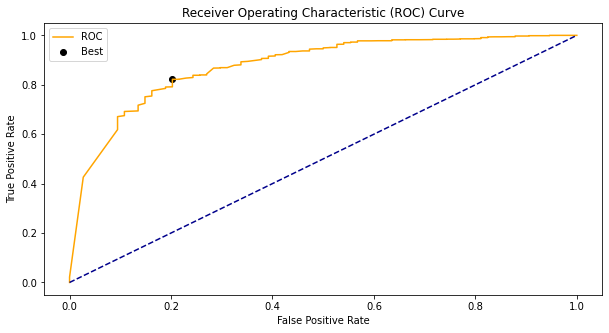

accuracy score:  82.1334503950834
              precision    recall  f1-score   support

         0.0       0.13      0.80      0.22        74
         1.0       0.99      0.82      0.90      2204

    accuracy                           0.82      2278
   macro avg       0.56      0.81      0.56      2278
weighted avg       0.96      0.82      0.88      2278



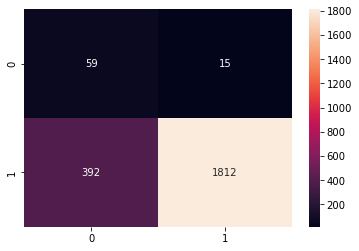



 ===========   Test Dataset    =============
Threshold value is: 0.9840523382685697


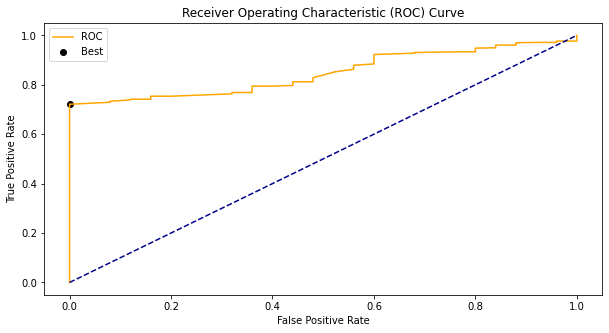

accuracy score:  73.02631578947368
              precision    recall  f1-score   support

         0.0       0.11      1.00      0.20        25
         1.0       1.00      0.72      0.84       735

    accuracy                           0.73       760
   macro avg       0.55      0.86      0.52       760
weighted avg       0.97      0.73      0.82       760



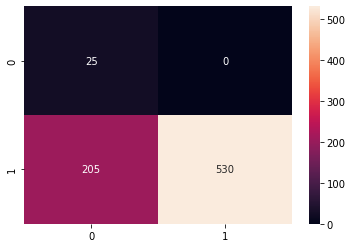



 ===========   ROC    =============
roc_auc = 0.8473


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [1.         0.72108844]
balanced accuracy:  0.8605442176870748
f1 0.7302631578947368


In [24]:
model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.01,
                         scale_pos_weight=7,
                         max_depth =3, random_state=0 )
                   

model = cross_val_with_missing_val(model,10)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()



# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('balanced accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test,  average = 'micro'))

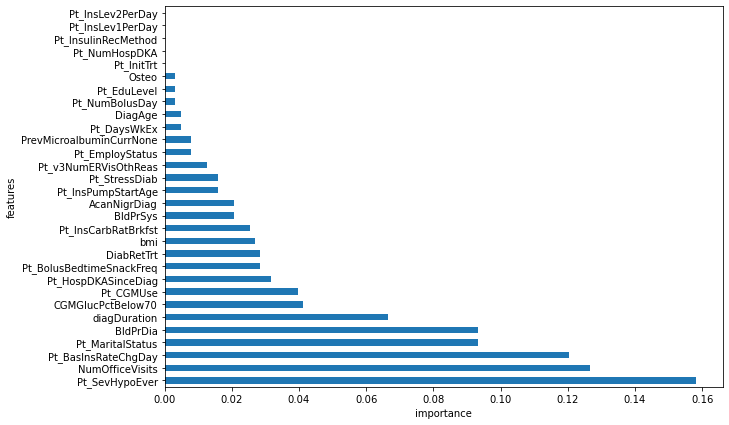

In [25]:
# feature importance graph of XGB
plt.figure(figsize=(10,7))

feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feature_importances = pd.Series((model.feature_importances_ / sum(model.feature_importances_)), index=X_train_copy.columns[0:204])
feature_importances.nlargest(30).plot(kind='barh')
plt.xlabel("importance")
plt.ylabel("features")
plt.savefig('fiSHMale.png', bbox_inches='tight')

In [42]:

row_to_show = 94 
data_for_prediction = X_test_copy.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])


print('sample', data_for_prediction_array)

model.predict_proba(data_for_prediction_array)



predictoin [1]
actial 1.0
sample [[  1.           1.           0.           1.           0.
    0.           0.           0.           0.           0.
    3.           0.           6.           8.           7.
    0.           2.           0.           3.           3.
    1.          35.           6.          18.           3.
    2.           8.           0.           1.                  nan
           nan   0.                  nan   0.                  nan
    0.                  nan          nan   4.           1.
    2.           2.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           2.                  nan   4.           1.
    3.          10.                  nan          nan   6.
    4.           1.           2.           2.           0.
    1.           1.           1.           2.          90.71940488
    0.           1.           1.          96.6161662           nan
  112.          74.           0.           0.     

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


array([[0.0132856, 0.9867144]])

In [46]:
from scipy.special import expit, logit

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_array)


shap.initjs()
import matplotlib.pyplot as pl
shap.force_plot(explainer.expected_value[0], shap_values[1], data_for_prediction, link='logit', show=True, matplotlib=True)
plt.savefig('SH-male.png' ,bbox_inches='tight')



In [35]:
# get shap value array
sv = shap_values[1][0,:]

# map feature names and it's values
mapping = dict(zip(X_train_copy.columns.tolist(), list(data_for_prediction)))
data = list(mapping.values())
key = list(mapping.keys())
features = []

for i, val in enumerate(key):
    a = val+'='+ str(data[i])
    features.append(a)


# filter features that SHAP value is not 0
new_sv = []
new_features = []
for i, val in enumerate(sv):
    if(sv[i] != 0.0 ):
        new_sv.append(sv[i])
        new_features.append(features[i])

print(new_sv)
print(new_features)

[0.10183525808914488, 0.001749693766703189, 0.0011463517491957737, 0.015010576090929954, -0.007171228325157502, 0.027966655607250836, 0.0008383231613969427, 0.02893467751915968, 0.000747978107090084, -0.003988837098965181, 0.0009504556042280272, 0.028294955913736774, 0.0012395406553181469, 0.000609807270363309, 0.0017590435176873674, 0.002106256437754031, 0.0032723080005524524, -0.08553453281077941, -0.012703670181296249, 0.0005007713803225255, 0.0030738911269568856, 0.0006146137031698996, 0.002132461741416847, 0.00017485655639421096, -0.0016865806500437034]
['Pt_SevHypoEver=1.0', 'Pt_HospDKASinceDiag=0.0', 'Pt_InsCarbRatBrkfst=6.0', 'Pt_BolusBedtimeSnackFreq=3.0', 'Pt_InsPumpStartAge=35.0', 'Pt_BasInsRateChgDay=2.0', 'Pt_NumBolusDay=8.0', 'Pt_CGMUse=1.0', 'Pt_DaysWkEx=4.0', 'Pt_StressDiab=3.0', 'Pt_EduLevel=10.0', 'Pt_MaritalStatus=2.0', 'Pt_EmployStatus=2.0', 'BldPrSys=112.0', 'BldPrDia=74.0', 'CGMGlucPctBelow70=nan', 'AcanNigrDiag=2.0', 'NumOfficeVisits=7.0', 'DiabRetTrt=2.0', 'Prev

In [28]:
# Sorting feature list based on values from SHAP list
sorted_features = [x for _,x in sorted(zip(new_sv,new_features),reverse=True)]

# sort shap valule list
sorted_sv = sorted(new_sv,reverse=True)

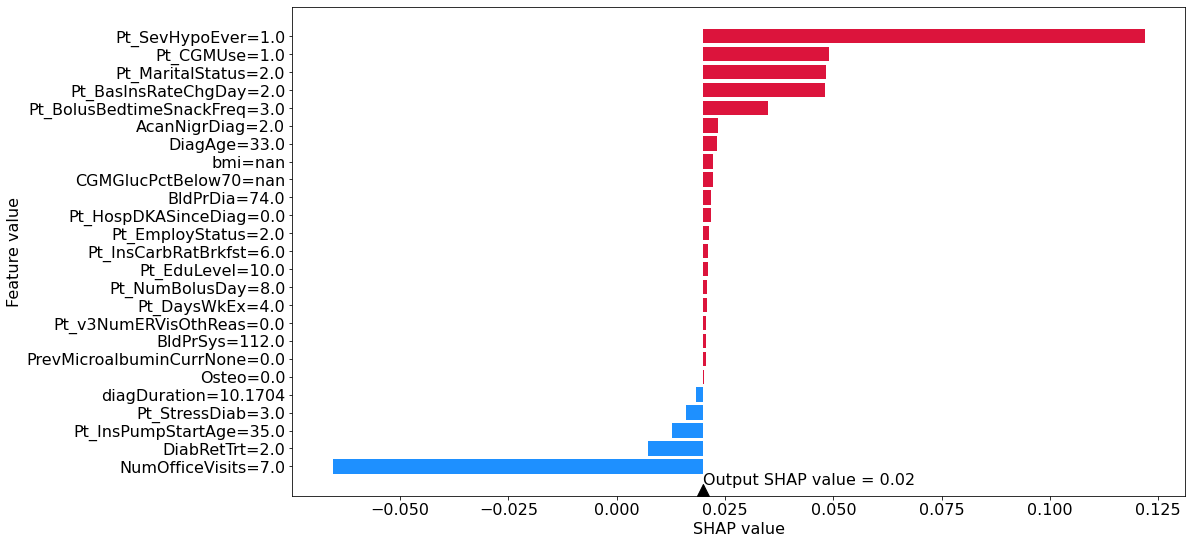

In [29]:
# expected value
threshold = 0.02

plt.rcParams.update({'font.size': 16})

# set bar color
color = ['crimson' if e >= 0.00 else 'dodgerblue' for e in sorted_sv]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(sorted_features, sorted_sv, color=color, left = threshold)

ax.annotate('Output SHAP value = 0.02', xy=(threshold,25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

# Show top values
ax.invert_yaxis()
plt.xlabel('SHAP value', fontsize=16)
plt.ylabel('Feature value', fontsize=16)

plt.savefig('SH-male-local-interpret.png' ,bbox_inches='tight')

# Show Plot
plt.show()